#  Zbiór danych Titanic, kto i dlaczego przeżył 


*Zosia Polak, Natalia Przewdzięk, Roksana Rymarek, Weronika Jaszkiewicz*

# DOKUMENTACJA PROJEKTU TITANIC

# 1. Cele

1. Dokładna analiza dostępnych danych oraz przedstawienie wyników w formie czytelnych wykresów, bazujących na różnych parametrach, takich jak płeć, wiek, klasa podróży, czy posiadanie rodzeństwa/rodzica na pokładzie, które mogły mieć związek z przeżyciem pasażerów.
2. Zdobycie umiejętności w pracy z danymi oraz w zastosowaniu uczenia maszynowego.
3. Stworzenie aplikacji, która pozwoli nam ocenić, czy dana osoba z określonymi parametrami miałaby większe szanse na przeżycie katastrofy Titanica, czy też nie. 

# 2. Wczytanie danych i wstępny ich przegląd i wizualizacja

**2.1 Import niezbędnych modułów**


using DataFrames - Pakiet DataFrames przechowuje dane w formie tabelarycznej z odpowiednio opisanymi wierszami i kolumnami.

using Plots - Pakiet Plots zapewnia ujednolicony interfejs i zestaw narzędzi do tworzenia wykresów.

using CSV  - Pakiet CSV służy do bardzo łatwego importowania lub eksportowania danych i tabel.

using HTTP - Pakiet HTTP zapewnia funkcjonalność zarówno klienta jak i serwera dla protokołów http i websocket.

using Random - Pakiet do losowania liczb pseudolosowych

using  GLM - Pakiet do dopasowywania i analizy modeli liniowych ogólnego zastosowania

using DecisionTree - Pakiet do tworzenia i obsługi modeli drzewa decyzyjnego.

using RDatasets - dataset: Pakiet zawierający zbiory danych do ćwiczeń i testów.

using MLJ - Pakiet do uczenia maszynowego metodą Drzewa decyzyjnego.

using ScikitLearn -  Pakiet umożliwiający integrację z narzędziami Scikit-Learn do uczenia maszynowego.

using Flux -  biblioteka dobudowy i trenowania sieci neuronowych.

using JLD2 - biblioteka w języku Julia, która umożliwia zapisywanie i odczytywanie struktur danych w formacie JLD2.





**2.2 Wczytanie danych i złączenie zbiorów**

#HTTP.request wysyła żądanie http i zwraca odpowiedź.

Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv" -  zbiór danych którego używamy 

response = HTTP.get(Titanic)

#Odczytuje dane CSV z obiektu odpowiedzi HTTP, tworzy obiekt DataFrame do przechowywania danych i przypisuje DataFrame do zmiennej titanic_data.

titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

**2.3 Wstępny przegląd danych**

Przyjżyjmy się teraz co zawiera nasz zbiór. Głównym celem jest przewidzenie wartości wartości zmiennej Survival, a więc informacji czy pasażer przeżył, czy też nie, przy użyciu 9-ciu pozostałych zmiennych (predyktorów), które zostały opisane poniżej:


    survival – czy pasażer przeżył
    class – klasa, którą podróżował 
    name – imię, nazwisko
    sex – płeć
    age – wiek
    sibsp – ilość rodzeństwa
    parch – ilość dzieci lub rodziców
    ticket – numer biletu
    fare – cena biletu
    cabin – numer kajuty
    embarked – port, w ktorym osoba wsiadła na pokład 
    boat – numer łódki, która się ewakuował
    body – numer identyfikacyjny znalezionego ciała



Przykładowy sampel z wierszami, którymi używamy w naszej analizie. Od razu, usuniemy kolumny, które na ten moment, nas nie interesują.

In [13]:
using DataFrames
using Plots 
using CSV
using HTTP


# wczytujemy bazę danych
Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame) 

first(titanic_data, 5)
select!(titanic_data, Not([:ticket, :fare, :boat, :body, :cabin]))

Row,pclass,survived,name,sex,age,sibsp,parch,embarked,home_dest
,Int64,Int64,String,String7,Float64?,Int64,Int64,String1?,String?
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,S,"St Louis, MO"
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,S,"Montreal, PQ / Chesterville, ON"
5,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,S,"Montreal, PQ / Chesterville, ON"
6,1,1,"Anderson, Mr. Harry",male,48.0,0,0,S,"New York, NY"
7,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0,1,0,S,"Hudson, NY"
8,1,0,"Andrews, Mr. Thomas Jr",male,39.0,0,0,S,"Belfast, NI"
9,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,S,"Bayside, Queens, NY"


# 3.WYKRESY



***1.WYKRES OCALAŁYCH***

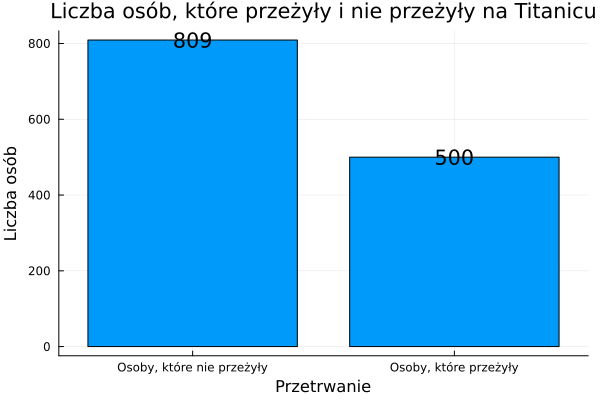

In [14]:
using DataFrames
using Plots 
using CSV
using HTTP


# wczytujemy bazę danych
Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

"""
    plot_survival(titanic_file)

Funkcja `plot_survival` generuje wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu.

"""
function plot_survival(titanic_file)
    # tworzymy nową tabelę zawierającą tylko kolumny Survived i Sex
    survived_sex = select(titanic_data, [:survived, :sex])

    # grupujemy tabelę według kolumny Survived i zliczamy liczbę wystąpień dla każdej wartości w kolumnie Sex
    survived_sex_counts = combine(groupby(survived_sex, :survived), nrow=>:SexCount)

    # generujemy wykres słupkowy
    bar(survived_sex_counts[!, :survived], survived_sex_counts[!, :SexCount], 
        xticks=(0:1, ["Osoby, które nie przeżyły", "Osoby, które przeżyły"]), 
        xlabel="Przetrwanie", 
        ylabel="Liczba osób", 
        title="Liczba osób, które przeżyły i nie przeżyły na Titanicu",
        text=survived_sex_counts[!, :SexCount],
        textposition=:center,
        legend=false)

end
plot_survival(Titanic)

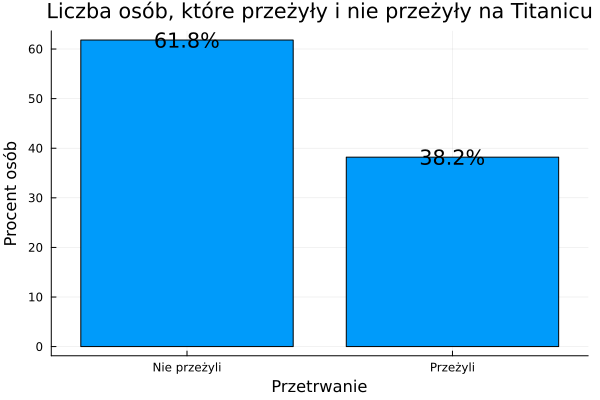

In [1]:
using DataFrames
using Plots 
using CSV
using HTTP


# wczytujemy bazę danych
Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

"""
    plot_survival_percentages(titanic_file)

Funkcja `plot_survival_percentages` generuje wykres słupkowy prezentujący procentową liczbę osób, 
które przeżyły i nie przeżyły na Titanicu.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący procentową liczbę osób, które przeżyły i nie przeżyły na Titanicu.

"""
function plot_survival_percentages(titanic_file)
    # wybieramy tylko kolumny "Survived" i "Sex"
    survived_sex = select(titanic_data, [:survived, :sex])

    # grupujemy po "Survived" i obliczamy sumę dla każdej kategorii płci
    grouped_survived_sex = groupby(survived_sex, :survived)
    total_counts = combine(grouped_survived_sex, :sex => length => :SexCount)
    total_counts.SexCount = total_counts.SexCount ./ sum(total_counts.SexCount) * 100

    # generujemy wykres słupkowy
    bar(total_counts.survived, total_counts.SexCount,
        xticks=(0:1, ["Nie przeżyli", "Przeżyli"]), 
        xlabel="Przetrwanie", 
        ylabel="Procent osób", 
        title="Liczba osób, które przeżyły i nie przeżyły na Titanicu",
        text=map(x -> string(round(x, digits=2), "%"), total_counts.SexCount),
        textposition=:center,
        legend=false)

end

plot_survival_percentages(Titanic)


WNIOSKI Z WYKRESU: Przeżyło 809 osób, czyli 61,8% osób obecnych na statku.

***2.WYKRES OCALAŁYCH W ZALEŻNOŚCI OD PŁCI***

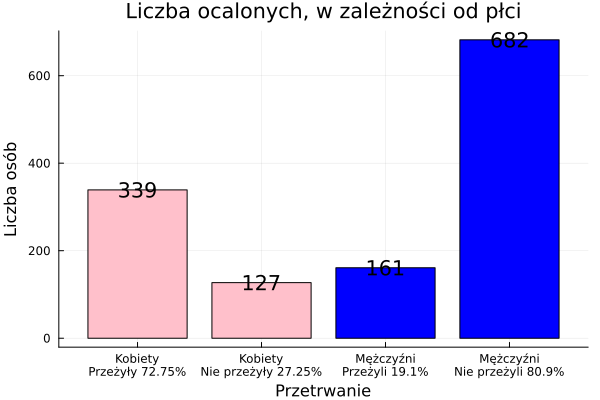

In [3]:
using DataFrames
using Plots 
using CSV
using HTTP


# wczytujemy bazę danych
Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

"""
    plot_survival_by_sex(titanic_file)

Funkcja `plot_survival_by_sex` generuje wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu
w zależności od płci.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca 
Wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu w zależności od płci.

"""
function plot_survival_by_sex(titanic_file)
    # tworzymy nową tabelę zawierającą tylko kolumny Survived i Sex
    survived_sex = select(titanic_data, [:survived, :sex])

    # grupujemy tabelę według kolumny Survived i Sex i zliczamy liczbę wystąpień
    survived_sex_counts = combine(groupby(survived_sex, [:survived, :sex]), nrow => :Count)

    # dzielimy tabelę na dwie osobne, dla kobiet i mężczyzn
    women_counts = filter(row -> row.sex == "female", survived_sex_counts)
    men_counts = filter(row -> row.sex == "male", survived_sex_counts)

    women_survival_rate = women_counts[women_counts.survived .== 1, :Count][1] / sum(women_counts[:, :Count])
    men_survival_rate = men_counts[men_counts.survived .== 1, :Count][1] / sum(men_counts[:, :Count])

    # generujemy wykres słupkowy
    bar(["Kobiety\nPrzeżyły $(round(women_survival_rate*100, digits=2))%",
         "Kobiety\nNie przeżyły $(round((1-women_survival_rate)*100, digits=2))%",
         "Mężczyźni\nPrzeżyli $(round(men_survival_rate*100, digits=2))%",
         "Mężczyźni\nNie przeżyli $(round((1-men_survival_rate)*100, digits=2))%"],
        [women_counts[women_counts.survived .== 1, :Count][1],
         women_counts[women_counts.survived .== 0, :Count][1],
         men_counts[men_counts.survived .== 1, :Count][1],
         men_counts[men_counts.survived .== 0, :Count][1]],
        color=["pink", "pink", "blue", "blue"],
        xlabel="Przetrwanie",
        ylabel="Liczba osób",
        title="Liczba ocalonych, w zależności od płci",
        text=([women_counts[women_counts.survived .== 1, :Count][1],
               women_counts[women_counts.survived .== 0, :Count][1],
               men_counts[men_counts.survived .== 1, :Count][1],
               men_counts[men_counts.survived .== 0, :Count][1]]),
        legend=false)
end

plot_survival_by_sex(Titanic)

WNIOSKI Z WYKRESU: Procentowo przeżyło więcej kobiet niż mężczyzn. Oznacza to, że w momencie ewakuacji pierwszeństwo miały kobiety.

***3.WYKRES OCALAŁYCH W ZALEŻNOŚCI OD WIEKU***

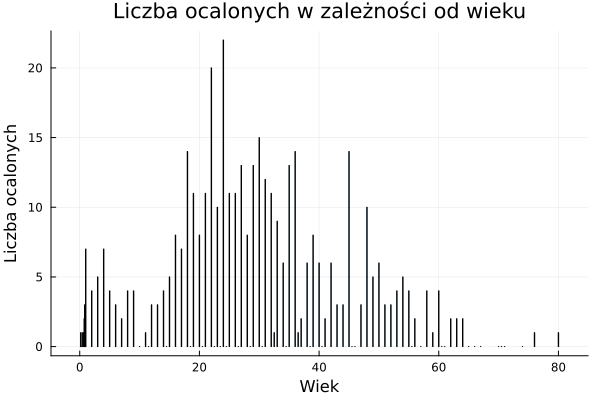

In [2]:
using DataFrames
using Plots 
using CSV
using HTTP


# wczytujemy bazę danych
Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

"""
    plot_survival_by_age(titanic_file)

Funkcja `plot_survival_by_age` generuje wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu
w zależności od wieku.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu w zależności od wieku.

"""
function plot_survival_by_age(titanic_file)

    titanic_data = CSV.read(IOBuffer(response.body), DataFrame) 
    titanic_data = titanic_data[.!ismissing.(titanic_data[!, :age]) .& .!ismissing.(titanic_data[!, :survived]), :]

    # tworzymy nową tabelę zawierającą tylko kolumny age
    survivors_by_age = combine(groupby(titanic_data, :age), :survived => sum)

    ages = Float64[]
    num_survivors = Int64[]
    for row in eachrow(survivors_by_age)
        push!(ages, row.age)
        push!(num_survivors, row.survived_sum)
    end

    # generujemy wykres słupkowy
    bar(ages, num_survivors, xlabel="Wiek", ylabel="Liczba ocalonych",
        title="Liczba ocalonych w zależności od wieku", legend=false)
end

plot_survival_by_age(Titanic)

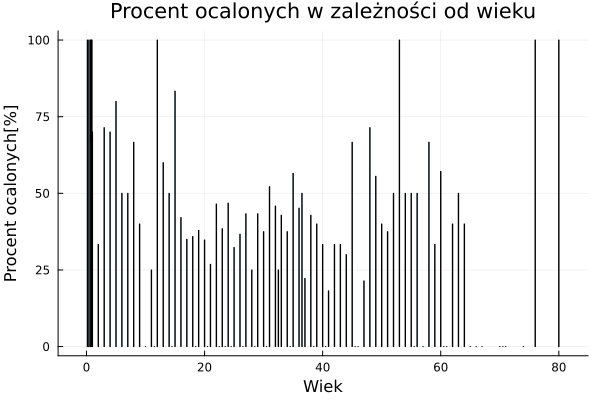

In [3]:
using DataFrames
using Plots 
using CSV
using HTTP


# wczytujemy bazę danych
Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

"""
    plot_survival_by_age_percentages(titanic_file)

Funkcja `plot_survival_by_age_percentages` generuje wykres słupkowy prezentujący procentową liczbę osób, które 
przeżyły i nie przeżyły na Titanicu w zależności od wieku.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący procentową liczbę osób, które przeżyły i nie przeżyły na Titanicu w zależności od wieku.

"""
function plot_survival_by_age_percentages(titanic_file)
    
    titanic_data = CSV.read(IOBuffer(HTTP.get(Titanic).body), DataFrame)
    titanic_data = titanic_data[.!ismissing.(titanic_data[!, :age]) .& .!ismissing.(titanic_data[!, :survived]), :]

    # grupujemy tabelę według wieku i sumujemy liczbę ocalonych i zmarłych
    survivors_by_age = combine(groupby(titanic_data, :age), 
                            :survived => sum => :survived_sum, 
                            :survived => length => :total_passengers)

    # obliczamy procentowy udział ocalonych dla każdej grupy wiekowej
    survivors_by_age[:, :SurvivalRate] = 100 .* survivors_by_age[:, :survived_sum] ./ survivors_by_age[:, :total_passengers]

    # generujemy wykres słupkowy
    bar(survivors_by_age[!, :age], survivors_by_age[!, :SurvivalRate], 
        xlabel="Wiek", 
        ylabel="Procent ocalonych[%]", 
        title="Procent ocalonych w zależności od wieku", 
        legend=false)
end

plot_survival_by_age_percentages(Titanic)

***WNIOSKI Z WYKRESU:***
 Najwięcej osób przeżyło w wieku od 20 do 35. A najmniej pasażerów w wieku dziecięcym i około 60 roku życia. Jednak biorąc pod uwagę analizę procentową, największe szanse przeżycia miały dzieci oraz osoby starsze. Z wykresu łatwo odczytać, że średnio 80% dzieci na pokładzie zostało uratowanych. Słupki spadają w okoliach 20. roku życia, a rosną znów w okolicach 60. roku życia. 


Zaistaniała sytuacja jest przyczyną zasady ewakuacji, w której najpierw ratowane są dzieci oraz osoby starsze, potrzebujące największej opieki.


***4.WYKRES PRZEŻYCIA W ZALEŻNOŚCI OD KLASY*** 

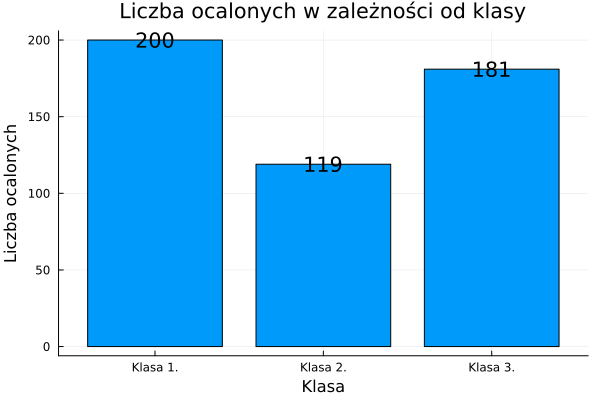

In [12]:
using DataFrames
using Plots 
using CSV
using HTTP


Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame) 

"""
    plot_survival_by_class(titanic_file)

Funkcja `plot_survival_by_class` generuje wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu 
w zależności od klasy podróżujących na Titanicu.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu w zależności od klasy podróżujących na Titanicu.

"""
function plot_survival_by_class(titanic_file)

    survivors_by_class = combine(groupby(titanic_data, :pclass), :survived => sum)

    klasy = Int[]
    ocaleni = Int[]
    for row in eachrow(survivors_by_class)
        push!(klasy, row.pclass)
        push!(ocaleni, row.survived_sum)
    end

    # generujemy wykres słupkowy
    bar(klasy, ocaleni,
        xticks=(1:3, ["Klasa 1.", "Klasa 2.", "Klasa 3."]),
        xlabel="Klasa",
        ylabel="Liczba ocalonych",
        title="Liczba ocalonych w zależności od klasy",
        text=ocaleni,
        legend=false)
end
plot_survival_by_class(Titanic)

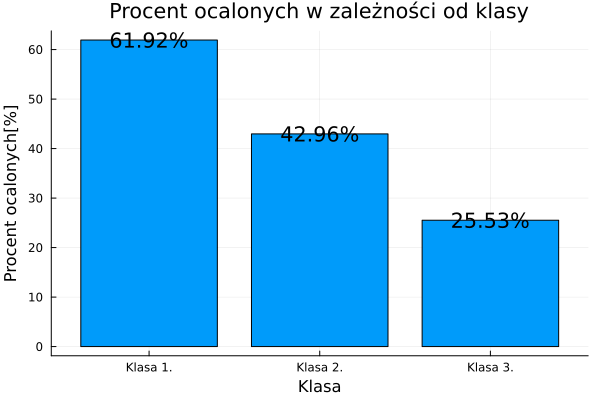

In [7]:
using DataFrames
using Plots 
using CSV
using HTTP
using Statistics


Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame) 

"""
    plot_survival_by_class_percentage(titanic_file)

Funkcja `plot_survival_by_class_percentage` generuje wykres słupkowy przedstawiający procent osób, które przeżyły 
i nie przeżyły na Titanicu w zależności od klasy podróżujących na Titanicu.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy przedstawiający procent osób, które przeżyły i nie przeżyły na Titanicu w zależności od klasy podróżujących na Titanicu.

"""
function plot_survival_by_class_percentage(titanic_file)
   
    survivors_by_class = combine(groupby(titanic_data, :pclass), :survived => mean)
    
    klasy = Int[]
    procent_ocalonych = Float64[]
    for row in eachrow(survivors_by_class)
        push!(klasy, row.pclass)
        push!(procent_ocalonych, 100*row.survived_mean)
    end
    
        # generujemy wykres słupkowy
    bar(klasy, procent_ocalonych,
        xticks=(1:3, ["Klasa 1.", "Klasa 2.", "Klasa 3."]),
        xlabel="Klasa",
        ylabel="Procent ocalonych[%]",
        title="Procent ocalonych w zależności od klasy",
        text=string.(round.(procent_ocalonych,digits=2), "%"), # zaokrąglamy do dwóch miejsc po przecinku
         legend=false)
end
    
plot_survival_by_class_percentage(Titanic)

WNIOSKI Z WYKRESU: Największa przeżywalność była wsród osób podróżujących pierwszą klasą, póżniej odpowiednio drugą i trzecią. Znaczy to, że w momencie ewakuacji pierwszeństwo miały osoby wyższe klasą.

4.***WYKRES OCALAŁYCH W ZALEŻNOŚCI OD LICZBY RODZEŃSTWA*** 

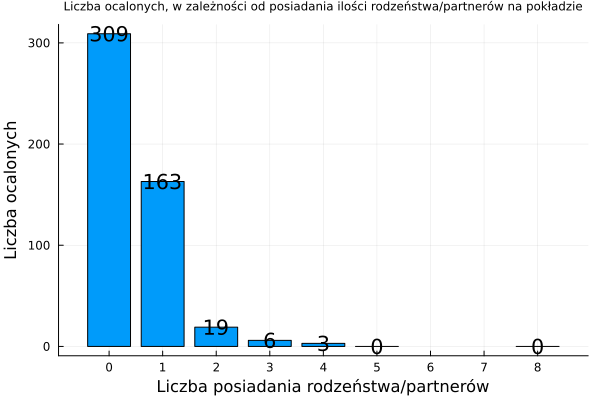

In [ ]:
using DataFrames
using Plots 
using CSV
using HTTP


Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame) 

"""
    plot_titanic_data(titanic_file)

Funkcja `plot_titanic_data` generuje wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu
 w zależności od liczby posiadanych rodzeństwa/partnerów na pokładzie Titanica.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu w zależności od liczby 
posiadanych rodzeństwa/partnerów na pokładzie Titanica.

"""
function plot_titanic_data(titanic_file) 




    titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

    titanic_data=dropmissing(titanic_data, [:sibsp, :survived])

    survivors_by_sibsp = combine(groupby(titanic_data, :sibsp), :survived => sum)

    ilość_rodzen=[]
    ocaleni=[]
    for row in eachrow(survivors_by_sibsp)
        push!(ilość_rodzen,row.sibsp)
        push!(ocaleni, row.survived_sum)
    end

    # generujemy wykres słupkowy
    bar(ilość_rodzen, ocaleni,
        xticks=(0:8,["0","1","2","3","4","5","6","7","8"]),
        xlabel="Liczba posiadania rodzeństwa/partnerów",
        ylabel="Liczba ocalonych",
        title="Liczba ocalonych, w zależności od posiadania ilości rodzeństwa/partnerów na pokładzie",
        titlefont=font(8), text=ocaleni, legend=false)
end
plot_titanic_data(Titanic)



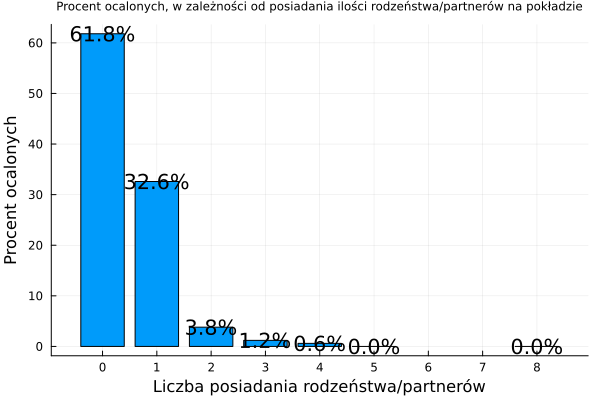

In [11]:
using DataFrames
using Plots 
using CSV
using HTTP


Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)  

"""
    plot_titanic_data_2(titanic_file)

Funkcja `plot_titanic_data_2` generuje wykres słupkowy prezentujący procent osób, które przeżyły i nie przeżyły na Titanicu
w zależności od liczby posiadanych rodzeństwa/partnerów na pokładzie Titanica.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący procent osób, które przeżyły i nie przeżyły na Titanicu w zależności od liczby 
posiadanych rodzeństwa/partnerów na pokładzie Titanica.

"""
function plot_titanic_data_2(titanic_file)  

    titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

    titanic_data=dropmissing(titanic_data, [:sibsp, :survived])

    survivors_by_sibsp = combine(groupby(titanic_data, :sibsp), :survived => sum)

    ilość_rodzen=[]
    ocaleni=[]
    for row in eachrow(survivors_by_sibsp)
        push!(ilość_rodzen,row.sibsp)
        push!(ocaleni, row.survived_sum)
    end

    # obliczamy całkowitą liczbę ocalałych dla każdej grupy sibsp
    total_survivors = sum(ocaleni)

    # oblicz procent ocalałych dla każdej grupy sibsp
    percent_survivors = (ocaleni ./ total_survivors) .* 100

    # generujemy wykres słupkowy
    bar(ilość_rodzen, percent_survivors,
        xticks=(0:8,["0","1","2","3","4","5","6","7","8"]),
        xlabel="Liczba posiadania rodzeństwa/partnerów",
        ylabel="Procent ocalonych",
        title="Procent ocalonych, w zależności od posiadania ilości rodzeństwa/partnerów na pokładzie",
        text=string.(round.(percent_survivors,digits=2), "%"),
        titlefont=font(8),
        legend=false)
end
plot_titanic_data_2(Titanic)


WNIOSKI Z WYKRESU: Przeżyła największa liczba osób, która nie posiadała rodzeństwa.


4.***WYKRES OCALAŁYCH W ZALEŻNOSCI OD POSIADANIA RODZICÓW/DZIECI***

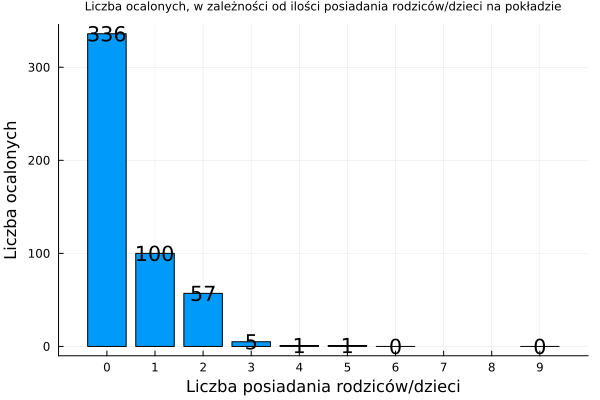

In [11]:
using DataFrames
using Plots 
using Statistics
using CSV
using HTTP

Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)  

"""
    plot_titanic_data2(titanic_file)

Funkcja `plot_titanic_data2` generuje wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu
w zależności od ilości posiadanych rodziców/dzieci na pokładzie Titanica.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący liczbę osób, które przeżyły i nie przeżyły na Titanicu w zależności od ilości 
posiadanych rodziców/dzieci na pokładzie Titanica.

"""
function plot_titanic_data2(titanic_file)

    titanic_data = CSV.read(IOBuffer(response.body), DataFrame)
    
    titanic_data = dropmissing(titanic_data, [:parch, :survived])

    survivors_by_parch = combine(groupby(titanic_data, :parch), :survived => sum)

    ilość_rodzicow = []
    ocaleni = []
    for row in eachrow(survivors_by_parch)
        push!(ilość_rodzicow, row.parch)
        push!(ocaleni, row.survived_sum)
    end

    # generujemy wykres słupkowy
    bar(ilość_rodzicow, ocaleni,
        xticks=(0:9, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]),
        xlabel="Liczba posiadania rodziców/dzieci",
        ylabel="Liczba ocalonych",
        title="Liczba ocalonych, w zależności od ilości posiadania rodziców/dzieci na pokładzie",
        titlefont=font(8), text=ocaleni, textfont=font(5), legend=false)
end
plot_titanic_data2(Titanic)

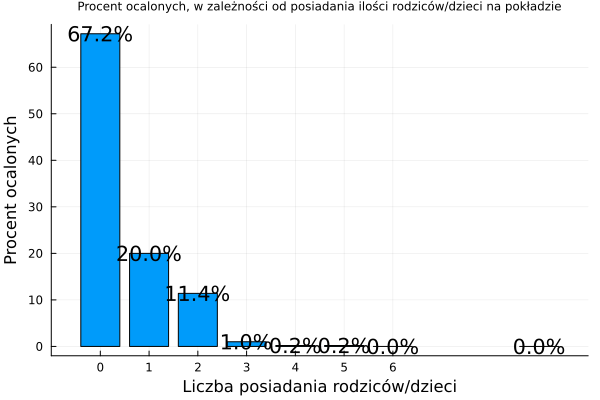

In [12]:
using DataFrames
using Plots 
using Statistics
using CSV
using HTTP

Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)  

"""
    plot_titanic_data2_2(titanic_file)

Funkcja `plot_titanic_data2_2` generuje wykres słupkowy prezentujący procent osób, które przeżyły i nie przeżyły na Titanicu
w zależności od ilości posiadanych rodziców/dzieci na pokładzie Titanica.

# Argumenty
- `titanic_file`: Nazwa pliku (adres URL) zawierającego dane dotyczące Titanica w formacie CSV.

# Zwraca
Wykres słupkowy prezentujący procent osób, które przeżyły i nie przeżyły na Titanicu w zależności od ilości 
posiadanych rodziców/dzieci na pokładzie Titanica.

"""
function plot_titanic_data2_2(titanic_file)  

    titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

    titanic_data=dropmissing(titanic_data, [:parch, :survived])

    survivors_by_parch = combine(groupby(titanic_data, :parch), :survived => sum)

    ilość_rodzicow = []
    ocaleni=[]
    for row in eachrow(survivors_by_parch)
        push!(ilość_rodzicow,row.parch)
        push!(ocaleni, row.survived_sum)
    end

    # obliczamy całkowitą liczbę ocalałych dla każdej grupy parch
    total_survivors = sum(ocaleni)

    # bliczamy procent ocalałych dla każdej grupy parch
    percent_survivors = (ocaleni ./ total_survivors) .* 100

    # generujemy wykres słupkowy
    bar(ilość_rodzicow, percent_survivors,
        xticks=(0:6,["0","1","2","3","4","5","6"]),
        xlabel="Liczba posiadania rodziców/dzieci",
        ylabel="Procent ocalonych",
        title="Procent ocalonych, w zależności od posiadania ilości rodziców/dzieci na pokładzie",
        text=string.(round.(percent_survivors,digits=2), "%"),
        titlefont=font(8),
        legend=false)
end

plot_titanic_data2_2(Titanic)


WNIOSKI Z WYKRESU: Przeżyła największa liczba osób, która nie miała rodziców na pokładzie.

# 4.Titanic i uczenie maszynowe

**1.Uczenie maszynowe**

Uczenie maszynowe (ang. machine learning) to dziedzina sztucznej inteligencji, która polega na tworzeniu i rozwijaniu algorytmów oraz modeli komputerowych, które są zdolne do uczenia się i podejmowania decyzji na podstawie danych. Głównym celem uczenia maszynowego jest umożliwienie maszynom automatycznego zdobywania wiedzy i doskonalenia swojego działania bez konieczności jawnego programowania.

Wybór odpowiedniej metody uczenia maszynowego zależy od rodzaju problemu, dostępnych danych oraz celu, który chcemy osiągnąć.
W naszym przypadku korzystaliśmy z:

1. Regresja logistyczna

2. Drzewa decyzyjne

3. Sieci neuronowe


**2. 1 Regresja logistyczna**

Regresja logistyczna to jedna z metod regresji używanych w statystyce w przypadku, gdy zmienna zależna jest na skali dychotomicznej, czyli przyjmuje jedynie dwie wartości - 0 lub 1. Zmienne objaśniające (niezależne) wskazują na wystąpienie lub brak wystąpienia zdarzenia, które chcemy prognozować. W naszym przypadku, zmienną zależną jest przeżycie katastrofy, a zmiennymi objaśniającymi są np. wiek lub płeć. Model pozwala wówczas na obliczanie prawdopodobieństwa tego zdarzenia. Regresja logistyczna przewiduje wartości prawdopodobieństwa, które są ograniczone do przedziału od 0 do 1. 

Analizując regresję logistyczną określamy czy dany predyktor (zmienna niezależna) jest istotna statystycznie w przyjętym modelu regresji. Dzięki temu możemy weryfikować postawione hipotezy badawcze, że dana zmienna ma wpływ na zmienną zależną.

Regresja logistyczna opiera się na specyficznym sposobie wyrażania prawdopodobieństwa, zwanym szansą. Określane jest przez stosuenk prawdopodobieństwa sukcesu do prawdopodobieństwa porażki.

Regresji logistycznej wykorzystuje sie np. do prognozowania ryzyka lub analizy danych medycznych.


***Obliczanie dokładności modelu***


In [1]:
using DataFrames
using Plots 
using Statistics
using CSV
using HTTP
using Random
using GLM

Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame) 

first(titanic_data, 5)

select!(titanic_data, Not([ :ticket, :fare, :boat, :body, :cabin, :embarked, :home_dest]))
dropmissing!(titanic_data)
titanic_data.sex=ifelse.(titanic_data.sex .== "male", 1, 0)

"""
    splitdf(df,pct)
    
Funckja 'splitdf()' dzieli podane dane na dane treningowe i testowe w podanej zależności.

# Argumenty:
    - df - dane, które chcemy podzielić (DataFrame)
    - pct - procentowy podział danych, określający proporcję danych treningowych, dana powinna mieć wartość między 0 a 1, gdzie 0 oznacza brak danych treningowych, a 1 oznacza brak danych testowych.
    
# Zwracane wartości:
    [train,test] - wektor, na pierwszej współrzędnej dane trenigowe, a na drugiej dane testowe
    
"""
function splitdf(df, pct)
    @assert 0 <= pct <= 1
    ids = collect(axes(df, 1))
    shuffle!(ids)
    sel = ids .<= nrow(df) .* pct
    train=view(df, sel, :)
    test=view(df, .!sel, :)
    return [train, test]
end

lista_danych=[]
for i in splitdf(titanic_data,0.7)
    push!(lista_danych,i)
end

train_data=lista_danych[1]
test_data=lista_danych[2]

#wybieranie kolumn danych na trening i test
target_train=select(train_data,[:survived])
feature_train=select(train_data,[:age, :sex, :pclass, :parch, :sibsp])

target_test=select(test_data,[:survived])
feature_test=select(test_data,[:age, :sex, :pclass, :parch, :sibsp])

#model z treningiem
logreg = glm(@formula(survived ~ sex + age +pclass + parch + sibsp), train_data, Binomial(), ProbitLink())
#predykcja z danymi testowymi
prediction=predict(logreg,test_data)
prediction_class = [if x < 0.5 0 else 1 end for x in prediction]
prediction_df = DataFrame(y_actual = test_data.survived, y_predicted = prediction_class, prob_predicted = prediction);
prediction_df.correctly_classified = prediction_df.y_actual .== prediction_df.y_predicted
#trafność modelu
accuracy = mean(prediction_df.correctly_classified)
dokl=round(accuracy*100,digits=2)
println("Dokładność modelu wynosi $dokl %")

Dokładność modelu wynosi 78.98 %


***Obliczanie szansy przeżycia osoby z danymi parametrami***

In [7]:
using DataFrames
using Plots 
using Statistics
using CSV
using HTTP
using GLM

Titanic  = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)  # trzeba opisać co mamy w tabeli! 

first(titanic_data, 5)

select!(titanic_data, Not([ :ticket, :fare, :boat, :body, :cabin, :embarked, :home_dest]))
dropmissing!(titanic_data)
titanic_data.sex=ifelse.(titanic_data.sex .== "male", 1, 0)

logreg = glm(@formula(survived ~ sex + pclass + age +parch + sibsp) ,titanic_data, Binomial(), ProbitLink())

#podajemy tu dane osob do predykcji
new_data=DataFrame(sex=1, pclass=3,age=80,parch=1,sibsp=0)
predicted_labels = predict(logreg, new_data)
j=predicted_labels[1]
j=round(100*j)
println("Prawdopodobieństwo przeżycia to $j %")

Prawdopodobieństwo przeżycia to 1.0 %


**3. 2.Decision tree learning**

Drzewo decyzyjne to jedna z popularnych metod uczenia maszynowego, wykorzystywana zarówno w uczeniu nadzorowanym, jak i nienadzorowanym. Jest to graficzna reprezentacja hierarchicznej struktury decyzyjnej, która pomaga podejmować decyzje lub przewidywać wartości na podstawie zestawu reguł.
Drzewa decyzyjne mają wiele zalet, takich jak łatwość interpretacji, możliwość obsługi zarówno danych kategorycznych, jak i numerycznych, efektywność obliczeniowa, a także odporność na brakujące dane. Jednakże, istnieje również ryzyko przetrenowania drzewa, co oznacza, że model może idealnie dopasować się do danych treningowych, ale będzie słabo generalizować na nowe dane.

***Obliczanie dokładności modelu***

In [1]:
using DataFrames
using DecisionTree
using RDatasets: dataset
using CSV
using MLJ
Titanic = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
titanic_data = DataFrame(CSV.File(download(Titanic)))

# Wybieranie interesujących kolumn i konwersja wartości 'sex' na wartości liczbowe
select!(titanic_data, Not([:ticket, :fare, :boat, :body, :cabin, :embarked, :home_dest]))
dropmissing!(titanic_data)
titanic_data.sex = ifelse.(titanic_data.sex .== "male", 1, 0)

"""
    split_data(df, pct)
    
Funckja 'split_data()' dzieli podane dane na dane treningowe i testowe w podanej zależności.

# Argumenty:
    - df - dane, które chcemy podzielić (DataFrame)
    - pct - procentowy podział danych, określający proporcję danych treningowych, dana powinna mieć wartość między 0 a 1, gdzie 0 oznacza brak danych treningowych, a 1 oznacza brak danych testowych.
    
# Zwracane wartości:
    [train,test] - wektor, na pierwszej współrzędnej dane trenigowe, a na drugiej dane testowe
    
"""
function split_data(df, pct)
    @assert 0 <= pct <= 1
    ids = collect(axes(df, 1))
    shuffle!(ids)
    sel = ids .<= nrow(df) .* pct
    train = view(df, sel, :)
    test = view(df, .!sel, :)
    return train, test
end

# Dzielenie danych na zestawy treningowe i testowe
train_data, test_data = split_data(titanic_data, 0.7)

# Wybieranie kolumn danych treningowych i testowych
target_train = Vector{Int}(train_data.survived)
feature_train = Matrix{Float64}(select(train_data, [:age, :sex, :pclass, :parch, :sibsp]))

target_test = Vector{Int}(test_data.survived)
feature_test = Matrix{Float64}(select(test_data, [:age, :sex, :pclass, :parch, :sibsp]))

# Utworzenie i dopasowanie modelu drzewa decyzyjnego
tree = build_tree(target_train, feature_train, 5)

# Przewidywanie na danych testowych
prediction = apply_tree(tree, feature_test)
prediction_df = DataFrame(y_actual = target_test, y_predicted = prediction)
prediction_df.correctly_classified = prediction_df.y_actual .== prediction_df.y_predicted

# Obliczanie trafności modelu
accuracy = sum(prediction_df.correctly_classified) / length(prediction_df.correctly_classified)
dokladnosc = round(accuracy * 100, digits = 2)
println("Dokładność modelu wynosi $dokladnosc %")



Dokładność modelu wynosi 78.34 %


***Obliczanie prawdopodobieństwa przeżycia osoby z danymi parametrami  na podstawie modelu***

In [1]:
using DataFrames
using ScikitLearn
using ScikitLearn: @sk_import
using CSV
using DecisionTree

# Ładowanie danych Titanic
Titanic = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
titanic_data = DataFrame(CSV.File(download(Titanic)))

# Przetwarzanie danych
select!(titanic_data, Not([:ticket, :fare, :boat, :body, :cabin, :embarked, :home_dest]))
dropmissing!(titanic_data)
titanic_data.sex = ifelse.(titanic_data.sex .== "male", 1, 0)

# Wybieranie kolumn danych treningowych
target_train = Vector{Int}(titanic_data.survived)
feature_train = Matrix{Float64}(select(titanic_data, [:age, :sex, :pclass, :parch, :sibsp]))

# Utworzenie i dopasowanie modelu drzewa decyzyjnego
@sk_import ensemble: RandomForestClassifier
tree_model = RandomForestClassifier(n_estimators=100, random_state=0)
ScikitLearn.fit!(tree_model, feature_train, target_train)

# Funkcja do przewidywania prawdopodobieństwa przeżycia dla konkretnej osoby
function predict_survival_probability(age, sex, pclass, parch, sibsp)
    feature = [age, sex, pclass, parch, sibsp]
    probability = ScikitLearn.predict_proba(tree_model, [feature])[:, 2][1]
    return probability
end

# Wprowadzenie danych konkretnej osoby i wyświetlenie prawdopodobieństwa przeżycia
age =80
sex = 1 # 1 dla mężczyzny, 0 dla kobiety
pclass = 3
parch = 1
sibsp = 0

probability = predict_survival_probability(age, sex, pclass, parch, sibsp)
rounded_probability = round(100 * probability)

println("Prawdopodobieństwo przeżycia osoby to $rounded_probability %")


Prawdopodobieństwo przeżycia osoby to 12.0 %

**4. 3. Sieci neuronowe** 

Sieci neuronowe są rodzajem modelu uczenia maszynowego inspirowanym strukturą i działaniem biologicznych neuronów w ludzkim mózgu. Są one używane do rozwiązywania problemów związanych z przetwarzaniem informacji, rozpoznawaniem wzorców, klasyfikacją danych i podejmowaniem decyzji.

W kontekście modelu przewidującego prawdopodobieństwo śmierci na Titanicu, sieć neuronowa może być użyta jako model uczenia maszynowego do klasyfikacji pasażerów na przetrwałych i nie przetrwałych.

Sieć neuronowa może przyjąć jako wejście różne cechy pasażerów, takie jak wiek, płeć, klasa podróży, liczba rodziców/dzieci na pokładzie, liczba rodzeństwa/partnerów na pokładzie itp. Każda cecha może być reprezentowana jako wartość liczbową lub binarną.

Sieć neuronowa składa się z warstw neuronów, gdzie każdy neuron w warstwie jest połączony z neuronami w kolejnych warstwach. Wejścia są propagowane przez sieć, a wagi połączeń są dostosowywane podczas procesu treningu, aby zminimalizować błąd predykcji.

Na końcu sieci neuronowej znajduje się warstwa wyjściowa z jednym neuronem, który generuje wynik w postaci prawdopodobieństwa przetrwania. Może to być liczba z zakresu 0 do 1, gdzie wartość bliska 0 oznacza wysokie prawdopodobieństwo śmierci, a wartość bliska 1 oznacza wysokie prawdopodobieństwo przetrwania.

Podczas treningu sieci neuronowej, wagi połączeń są aktualizowane na podstawie różnicy między przewidywanymi a rzeczywistymi wynikami. Sieć neuronowa jest uczona na podstawie danych treningowych, które zawierają informacje o losowych pasażerach i ich rzeczywistym statusie przetrwania.

Po zakończeniu treningu, sieć neuronowa może być używana do przewidywania prawdopodobieństwa śmierci dla nowych danych pasażerów. Wprowadzając cechy nowego pasażera do sieci, otrzymujemy wynik w postaci prawdopodobieństwa przetrwania.

Sieci neuronowe mają zdolność do nauki złożonych zależności i automatycznego wyodrębniania istotnych cech z danych. Dlatego mogą być skutecznym narzędziem w przypadku modelowania i predykcji prawdopodobieństwa przetrwania na podstawie różnych cech pasażerów na Titanicu.

In [9]:
using CSV, HTTP, DataFrames, Flux, Statistics, Random

Titanic = "http://analityk.edu.pl/wp-content/uploads/2020/02/titanic.csv"
response = HTTP.get(Titanic)
titanic_data = CSV.read(IOBuffer(response.body), DataFrame)

# Przygotowanie danych
select!(titanic_data, Not([:ticket, :fare, :boat, :body, :cabin, :embarked, :home_dest]))
dropmissing!(titanic_data)
titanic_data.sex = ifelse.(titanic_data.sex .== "male", 1, 0)

"""
    split_data(df, pct)

Funckja 'split_data()' dzieli podane dane na dane treningowe i testowe w podanej zależności.

# Argumenty:
    - df - dane, które chcemy podzielić (DataFrame)
    - pct - procentowy podział danych, określający proporcję danych treningowych, dana powinna mieć wartość między 0 a 1, gdzie 0 oznacza brak danych treningowych, a 1 oznacza brak danych testowych.

# Zwracane wartości:
    [train,test] - wektor, na pierwszej współrzędnej dane trenigowe, a na drugiej dane testowe
    
"""
function split_data(df, pct)
    @assert 0 <= pct <= 1
    ids = collect(axes(df, 1))
    shuffle!(ids)
    sel = ids .<= nrow(df) .* pct
    train = view(df, sel, :)
    test = view(df, .!sel, :)
    return train, test
end

train_data, test_data = split_data(titanic_data, 0.9)

# Wybór kolumn danych treningowych i testowych
feature_train = select(train_data, [:age, :sex, :pclass, :parch, :sibsp])
target_train = select(train_data, [:survived])

feature_test = select(test_data, [:age, :sex, :pclass, :parch, :sibsp])
target_test = select(test_data, [:survived])

# Skalowanie cech liczby rodziców lub rodzeństwa
feature_train.parch_scaled = feature_train.parch ./ maximum(feature_train.parch)
feature_train.sibsp_scaled = feature_train.sibsp ./ maximum(feature_train.sibsp)

feature_test.parch_scaled = feature_test.parch ./ maximum(feature_train.parch)
feature_test.sibsp_scaled = feature_test.sibsp ./ maximum(feature_train.sibsp)

# Konwersja danych do macierzy
feature_train = permutedims(Matrix(feature_train))
target_train = Matrix(target_train)
feature_test = permutedims(Matrix(feature_test))
target_test = Matrix(target_test)

# Definicja modelu sieci neuronowej
model = Chain(
  Dense(7, 64, relu),
  Dense(64, 2),
  softmax
)

# Funkcja straty i optymalizator
loss(x, y) = Flux.crossentropy(model(x), y)
optimizer = ADAM()

# Uczenie sieci neuronowej
Flux.train!(loss, Flux.params(model), [(feature_train, Flux.onehotbatch(target_train, 0:1))], optimizer)

# Predykcja na danych testowych
predictions = Flux.onecold(model(feature_test), 0:1)

# Obliczenie dokładności
accuracy = sum(predictions .== target_test) / length(target_test) * 100
result = round(accuracy, digits=2)
println("Dokładność modelu wynosi $result%")


Dokładność modelu wynosi 63.81%


In [21]:
using Flux, JLD2

# Wczytanie wytrenowanego modelu (dostosuj ścieżkę do swojego wytrenowanego modelu)
model = JLD2.load("sieci_neuronowe.jld2", "model")

# Funkcja do przewidywania prawdopodobieństwa przeżycia dla konkretnej osoby
function predict_survival_probability(age, sex, pclass, parch, sibsp)
    feature = [age, sex, pclass, parch, sibsp]
    feature_scaled = feature ./ maximum(feature_train[:, 4:5])
    feature_scaled = Flux.unsqueeze(feature_scaled, 1)
    feature_scaled = permutedims(feature_scaled)
    feature_scaled = Float32.(feature_scaled)
    output = model(feature_scaled)
    probability = output[2]
    return probability
end

# Wprowadzenie danych konkretnej osoby i wyświetlenie prawdopodobieństwa przeżycia
age = 80
sex = 1 # 1 dla mężczyzny, 0 dla kobiety
pclass = 3
parch = 1
sibsp = 0

probability = predict_survival_probability(age, sex, pclass, parch, sibsp)
rounded_probability = round(100 * probability)

println("Prawdopodobieństwo przeżycia osoby to $rounded_probability %")


Prawdopodobieństwo przeżycia osoby to 24.0 %


Niestety w naszym przypadku nie jest to najlepszy model. Niezależnie od wag połączeń czy wprowadzanych danych, model ma bardzo niską skuteczność?. Dlaczego? jest kilka powodów:

1. Niewystarczająca ilość danych treningowych: Sieci neuronowe często wymagają dużej ilości danych treningowych, aby nauczyć się odpowiednich wzorców i osiągnąć wysoką skuteczność. Jeśli dostępne dane treningowe są ograniczone, model może mieć trudności w generalizacji na nowe dane.

2. Zbyt mała architektura sieci: Jeśli architektura sieci jest zbyt prosta lub mało złożona, model może nie być w stanie wyodrębnić wystarczająco skomplikowanych wzorców w danych. W takim przypadku zwiększenie rozmiaru warstw lub dodanie dodatkowych warstw może pomóc w poprawie skuteczności.

3. Nieodpowiednie hiperparametry: Hiperparametry, takie jak współczynnik uczenia, liczba epok uczenia, czy regularyzacja (architektura sieci), mogą mieć duży wpływ na skuteczność modelu. Niewłaściwie dobrane hiperparametry mogą prowadzić do zbyt szybkiego uczenia się lub zbyt wolnego uczenia się, co może negatywnie wpływać na wyniki.

Nie znaczy to jednak, że sieci neuronowe są złym modelem. Są po prostu nieodpowiednie do naszego projektu oraz tego, co chcemy osiągnąć. Jednak przy bardziej złożonych algorytmach lub przy dużo większej bazie danych, metoda to może okazać się najskuteczniejsza. Dlatego też na potrzeby różnych projektów warto przetestować kilka metod i wybrać tę, która najbardziej odpowiada naszym wymaganiom oraz celom.

**5. PROGRAM PRZEWIDUJĄCY PRAWDOPODOBIEŃSTWO PRZEŻYCIA KATASTROFY TITANICA NA PODSTAWIE PARAMETRÓW UŻYTKOWNIKA**

  Do napisania programu użyłyśmy **modelu regresji logistycznej**, ponieważ model ten umożliwia nam interpretację wyników w kontekście szans i logarytmów szans. Możemy ocenić wpływ poszczególnych cech takich jak wiek, płeć, klasa, ilość rodzeństwa i rodziców na prawdopodobienstwo przeżycia. Dodatkowo regresja logistyczna jest w miarę prostym modelem, co ułatwia jego zrozumienie. Może być również stosunkowo efektywna obliczeniowo co jest ważne zwłaszcza jeśli mamy duże zbiory danych.

Pierwszym krokiem jest dopisanie kilku linijek do kodu z modelem regresji logistycznej. Używamy do tego paczki JLD2, która jest biblioteką w języku Julia, która umożliwia zapisywanie i odczytywanie struktur danych w formacie JLD2. Dzięki możliwości zapisywania i odczytywania struktur danych, JLD2 umożliwia przechowywanie wyników treningu modelu w jednym pliku.

In [ ]:
using JLD2

# Ścieżka do pliku, w którym chcesz zapisać model
model_file = "trained_model.jld2"

# Zapisz model
save(model_file, "logreg", logreg)

Plik trained_model.jld2 będzie zawierał zapisany wytrenowany model, który będzie można później odczytać.

Do ostatecznego kodu z programem przewidującym prawdopodobieństwo przeżycia dopisujemy kilka linijek, które zaimportują nasz wytrenowany model. 

In [ ]:
using JLD2

# Wczytanie modelu z pliku
model_file = "trained_model.jld2"
@load model_file logreg

**6. PODSUMOWANIE**

W naszym projekcie dotyczącym katastrofy Titanica udało nam się osiągnąć wszystkie zamierzone cele. Wykonywałyśmy różne wykresy, analizowałyśmy dane, zbadałyśmy skuteczność trzech modeli oraz stworzyłyśmy aplikacje, która oblicza prawdopodobieństwo przeżycia osoby na podstawie wprowadzonych danych. Zdobyłyśmy umiejętności w pracy z danymi oraz w zastosowaniu uczenia maszynowego. Projekt ten rozwinął nasze umiejętności analityczne i dostarczył praktycznej wiedzy z zakresu analizy danych.

***ŹRÓDŁA***

https://juliastats.org/GLM.jl/stable/

https://pl.wikipedia.org/wiki/Regresja_logistyczna

https://www.geeksforgeeks.org/logistic-regression-in-julia/?fbclid=IwAR3KwOkf5FgLyck8PB14JD8n-7rKTWXd-r1B1WCUAMsjGjkLEJ3mn8V2VuY

https://analityk.edu.pl/zbior-danych-titanic-analiza-w-python/

https://juliapackages.com/p/mlj
